# Import

In [1]:
from google.colab import drive

import torch
import torch.nn as nn

from google.colab import drive

import json
import cv2
import glob
import os
import time
import copy

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as utils
import torchvision.datasets as datasets


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import pandas as pd

from skimage import io, transform

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,classification_report

from torch.optim.lr_scheduler import StepLR ,ReduceLROnPlateau
from tqdm import tqdm




In [2]:
import numpy as np

import random
import matplotlib.patches as patches

import torchvision
from torchvision import ops
from torch.nn.utils.rnn import pad_sequence

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset & Dataloader

In [5]:

from torchvision.transforms import functional as F
class UnderwaterDataset(torch.utils.data.Dataset):
  def __init__(self, root , phase,img_size,transformer = None):
    self.root = root
    self.phase = phase
    self.imgs = os.listdir(os.path.join(root, '{}/images'.format(phase)))
    self.targets = os.listdir(os.path.join(root, '{}/labels'.format(phase)))
    self.imgs.sort()
    self.targets.sort()
    self.img_height = img_size[0]
    self.img_width = img_size[1]
    self.transformer = transformer

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, '{}/images'.format(self.phase), self.imgs[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (self.img_height,self.img_width))
    # img = Image.open(img_path).convert('RGB')
    img = F.to_tensor(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    #print(self.img_height , self.img_width )
    #print(img.shape)
    #
    target_path = os.path.join(self.root, '{}/labels'.format(self.phase), self.targets[idx])
    f = open(target_path , 'r')
    #print('nn')
    t = list(map(float ,f.read().split()))
    # print(t)
    labels = t[0::5]
    box_list = []
    for i in range(int(len(t)/5)):
        a = t[5*i+1:5*i+5].copy()
        # print(self.img_width ,self.img_height)
        box_x_center = a[0]*self.img_width
        box_y_center = a[1]*self.img_height
        box_width  = a[2]*self.img_width
        box_height = a[3]*self.img_height
        box_list.append([box_x_center - box_width/2 , box_y_center - box_height/2 , box_x_center + box_width/2 , box_y_center + box_height/2 ])
    boxes = torch.tensor(box_list, dtype=torch.float32)
    #
    labels = torch.tensor(labels, dtype=torch.int64)
    #
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    #

    # print(img.shape)
    return img, target

  def __len__(self):
    return len(self.imgs)

In [6]:
img_width = 256
img_height = 256
# data_transforms = #Fill This Part
name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
idx2name = {v:k for k, v in name2idx.items()}

In [7]:
train_dataset = UnderwaterDataset('/content/drive/MyDrive/aquarium_pretrain', 'train' , (img_width,img_height), transformer=transform)

torch.Size([3, 256, 256])


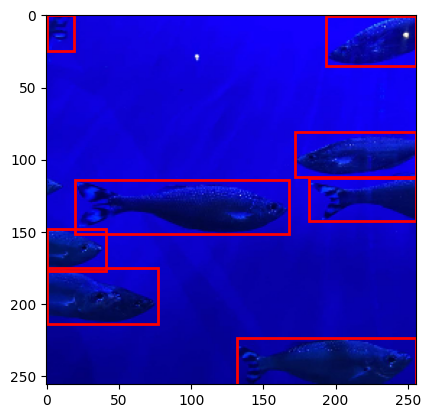

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
img , target = train_dataset.__getitem__(1)
np_arr = img.permute(1, 2, 0).numpy()
plt.imshow(np_arr)
print(img.shape)
boxes = target['boxes']
labels = target['labels']
ax = plt.gca()
for box, label in zip(boxes, labels):
  box = box.cpu().numpy()
  rect = Rectangle((box[0], box[1]),
                     (box[2] - box[0]),
                     (box[3] - box[1]),
                     fill=False,
                     edgecolor=(1, 0, 0),
                     linewidth=2)
  ax.add_patch(rect)

plt.show()

In [9]:
# od_dataset = ObjectDetectionDataset(train_list, (img_height, img_width), name2idx, data_transforms['train'])
# od_dataset_val = ObjectDetectionDataset(val_list, (img_height, img_width), name2idx, data_transforms['test'])
# od_dataset_test = ObjectDetectionDataset(test_list, (img_height, img_width), name2idx, data_transforms['test'])
od_dataset = UnderwaterDataset('/content/drive/MyDrive/aquarium_pretrain', 'train' , (img_width,img_height))
od_dataset_val = UnderwaterDataset('/content/drive/MyDrive/aquarium_pretrain', 'valid' , (img_width,img_height))
od_dataset_test = UnderwaterDataset('/content/drive/MyDrive/aquarium_pretrain', 'test' , (img_width,img_height))

In [33]:
numberofobejcet_train = {}
for i in range(len(od_dataset)):
  _ , target = od_dataset.__getitem__(i)
  n = len(target['labels'])
  if n in numberofobejcet_train.keys():
    numberofobejcet_train[n] += 1
  else :
    numberofobejcet_train[n] = 1
numberofobejcet_valid = {}
for i in range(len(od_dataset_val)):
  _ , target = od_dataset_val.__getitem__(i)
  n = len(target['labels'])
  if n in numberofobejcet_valid.keys():
    numberofobejcet_valid[n] += 1
  else :
    numberofobejcet_valid[n] = 1
numberofobejcet_test = {}
for i in range(len(od_dataset_test)):
  _ , target = od_dataset_test.__getitem__(i)
  n = len(target['labels'])
  if n in numberofobejcet_train.keys():
    numberofobejcet_test[n] += 1
  else :
    numberofobejcet_test[n] = 1


KeyError: 1

In [11]:
def new_concat(batch):
    images = []
    targets = []
    max_len = -1
    for img , target in batch:
      if len(target['labels']) > max_len:
        max_len = len(target['labels'])
    for img , target in batch:

      for i in range(max_len - len(target['labels']) ):
        target['boxes'] = torch.cat([target['boxes'], torch.zeros((1,4), dtype=torch.float32)], dim=0)
        target['labels']  = torch.cat([target['labels'], torch.zeros((1), dtype=torch.float32)], dim=0)
      images.append(img)
      targets.append(target)
    return torch.stack(images) , targets


In [12]:
collate_fn = lambda batch: new_concat(batch)
od_dataloader = DataLoader(od_dataset, batch_size=4 ,  collate_fn = collate_fn , drop_last=True ,shuffle=True)
od_dataloader_val = DataLoader(od_dataset_val, batch_size=4 ,  collate_fn = collate_fn , drop_last=True,shuffle=True)
od_dataloader_test = DataLoader(od_dataset_test, batch_size=4 ,  collate_fn = collate_fn , drop_last=True,shuffle=True)

In [13]:
train_features, train_labels = next(iter(od_dataloader))

print(f"Feature batch shape: {train_features.size()}")
# for i in train_features:
#   np_arr = i.permute(1, 2, 0).numpy()
#   plt.imshow(np_arr)
#   plt.show()
print(train_labels)
#print(f"Label: {label}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()

Feature batch shape: torch.Size([4, 3, 256, 256])
[{'boxes': tensor([[110.7500,  79.6667, 128.2500, 104.3333],
        [ 61.2500, 109.5000,  72.7500, 133.8333],
        [139.7500,  59.1667, 148.2500,  81.5000],
        [128.5000,  39.5000, 136.0000,  59.8333],
        [172.3750,  41.3333, 184.1250,  61.3333],
        [102.7500,  64.6667, 131.2500,  81.3333],
        [ 94.5000,  76.5000, 122.0000,  90.1667],
        [215.6250,  25.8333, 234.8750,  38.8333],
        [196.6250,  34.6667, 215.8750,  46.0000],
        [188.0000,  12.3333, 199.0000,  20.3333]]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}, {'boxes': tensor([[116.6667, 122.6250, 139.3333, 151.8750],
        [ 67.1667,  66.5000,  90.8333,  93.0000],
        [164.6667, 138.6250, 203.3333, 161.3750],
        [ 64.8333, 117.6250,  92.5000, 135.3750],
        [  0.0000, 103.8750,  20.0000, 121.1250],
        [ 28.5000, 118.7500,  52.8333, 135.2500],
        [112.8333,  64.6250, 136.5000,  77.8750],
        [  0.0000,   0.000

In [14]:
for img_batch, target_batch,  in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all =[]
    gt_classes_all = []
    for i in target_batch :
      gt_bboxes_all.append(i['boxes'])
      gt_classes_all.append(i['labels'])
    break


# Model

## Backbone model

In [15]:
def get_backbone_model(pretrained = True):
  backbone = models.resnet101(pretrained=True)
  modules = list(backbone.children())[:-2]
  return nn.Sequential(*modules)

In [16]:
backbone = get_backbone_model()

# run the image through the backbone
out = backbone(img_data_all)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 117MB/s]


In [17]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [18]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

## Generate and Plot Anchor Points

In [19]:
def generateanchorpoints(out_h, out_w,width_scale_factor,height_scale_factor):
  x_span = (np.arange(out_w)+0.5)*width_scale_factor
  y_span = (np.arange(out_h)+0.5)*height_scale_factor
  xx, yy = np.meshgrid(x_span, y_span)
  return xx , yy

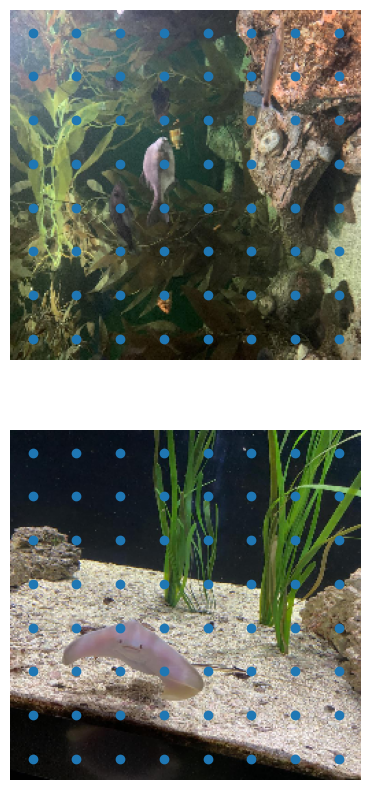

In [20]:
figure = plt.figure(figsize=(20,10))
xx , yy = generateanchorpoints(out_h, out_w,width_scale_factor,height_scale_factor)
figure.add_subplot(2, 1, 1)
img = img_data_all[0]
np_arr = img.permute(1, 2, 0).numpy()
plt.scatter(xx, yy)
plt.axis('off')
plt.imshow(np_arr)
figure.add_subplot(2, 1, 2)
img = img_data_all[1]
np_arr = img.permute(1, 2, 0).numpy()
plt.scatter(xx, yy)
plt.axis('off')
plt.imshow(np_arr)
plt.show()

## Create Anchor Boxes around Anchor points

In [21]:
def AnchorGenerator(anchorpoints, sizes,  aspect_ratios):
  xx = anchorpoints[0]
  yy = anchorpoints[1]
  anchorbox = []
  for i , j in zip(xx.flatten(),yy.flatten()):
    print(anchorbox)
    for s in sizes:
      for r in aspect_ratios:
        anchorbox.append([(i-s/2),(j-s*r/2),(i+s/2),(j+s*r/2)])
  anchorbox = np.array(anchorbox)
  return anchorbox

In [22]:
anchorbox = AnchorGenerator((xx, yy), (16,32, 64, 128),  (0.5, 1.0, 2.0))

[]
[[8.0, 12.0, 24.0, 20.0], [8.0, 8.0, 24.0, 24.0], [8.0, 0.0, 24.0, 32.0], [0.0, 8.0, 32.0, 24.0], [0.0, 0.0, 32.0, 32.0], [0.0, -16.0, 32.0, 48.0], [-16.0, 0.0, 48.0, 32.0], [-16.0, -16.0, 48.0, 48.0], [-16.0, -48.0, 48.0, 80.0], [-48.0, -16.0, 80.0, 48.0], [-48.0, -48.0, 80.0, 80.0], [-48.0, -112.0, 80.0, 144.0]]
[[8.0, 12.0, 24.0, 20.0], [8.0, 8.0, 24.0, 24.0], [8.0, 0.0, 24.0, 32.0], [0.0, 8.0, 32.0, 24.0], [0.0, 0.0, 32.0, 32.0], [0.0, -16.0, 32.0, 48.0], [-16.0, 0.0, 48.0, 32.0], [-16.0, -16.0, 48.0, 48.0], [-16.0, -48.0, 48.0, 80.0], [-48.0, -16.0, 80.0, 48.0], [-48.0, -48.0, 80.0, 80.0], [-48.0, -112.0, 80.0, 144.0], [40.0, 12.0, 56.0, 20.0], [40.0, 8.0, 56.0, 24.0], [40.0, 0.0, 56.0, 32.0], [32.0, 8.0, 64.0, 24.0], [32.0, 0.0, 64.0, 32.0], [32.0, -16.0, 64.0, 48.0], [16.0, 0.0, 80.0, 32.0], [16.0, -16.0, 80.0, 48.0], [16.0, -48.0, 80.0, 80.0], [-16.0, -16.0, 112.0, 48.0], [-16.0, -48.0, 112.0, 80.0], [-16.0, -112.0, 112.0, 144.0]]
[[8.0, 12.0, 24.0, 20.0], [8.0, 8.0, 24.0, 2

## plot anchor boxes on a single anchor point

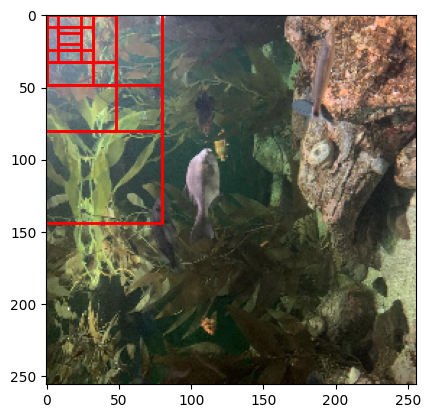

In [23]:
img = img_data_all[0]
np_arr = img.permute(1, 2, 0).numpy()
plt.imshow(np_arr)
ax = plt.gca()
for i in range(12):
  a = anchorbox[i]
  rect = Rectangle((a[0], a[1]),
                     (a[2] - a[0]),
                     (a[3] - a[1]),
                     fill=False,
                     edgecolor=(1, 0, 0),
                     linewidth=2)
  ax.add_patch(rect)

## plot all anchor boxes

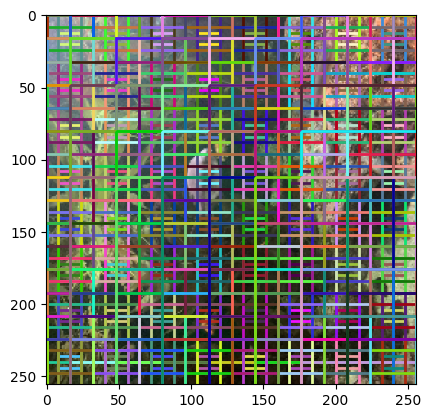

In [24]:
img = img_data_all[0]
np_arr = img.permute(1, 2, 0).numpy()
plt.imshow(np_arr)
ax = plt.gca()
for a in anchorbox:
  r1 = np.random.rand()
  r2 = np.random.rand()
  r3 = np.random.rand()
  rect = Rectangle((a[0], a[1]),
                     (a[2] - a[0]),
                     (a[3] - a[1]),
                     fill=False,
                     edgecolor=(r1, r2, r3),
                     linewidth=2)
  ax.add_patch(rect)

## Get Positive and Negative Anchors

## Building the model

In [ ]:
def giou(box1, box2):
    x1 = torch.max(box1[0], box2[0])
    y1 = torch.max(box1[1] box2[1])
    x2 = torch.min(box1[2], box2[2])
    y2 = torch.min(box1[3], box2[3])

    intersection = (x2 -x1) * (y2 - y1)
    b1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    b2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_= b1 + b2 - intersection
    iou = intersection / union

    x1 = torch.min(box1[0], box2[0])
    y1 = torch.min(box1[1] box2[1])
    x2 = torch.max(box1[2], box2[2])
    y2 = torch.max(box1[3], box2[3])

    c = (x2 - x1) * (y2 - y1)
    giou = iou - (c - union) / c
    return giou

In [ ]:
def project_bboxes_to_feature_map(gt_bboxes, img_width, img_height, feature_map_width, feature_map_height):
    projected_bboxes = []
    scale_x = feature_map_width / img_width
    scale_y = feature_map_height / img_height
    for bbox in gt_bboxes:
        projected_bbox = bbox.clone()
        projected_bbox[:, [0, 2]] *= scale_x
        projected_bbox[:, [1, 3]] *= scale_y
        projected_bboxes.append(projected_bbox)
    return torch.stack(projected_bboxes)

In [ ]:
def project_anchors_to_image_space(anchors, img_width, img_height):
    projected_anchors = anchors.clone()
    projected_anchors[:, [0, 2]] *= img_width
    projected_anchors[:, [1, 3]] *= img_height
    return projected_anchors

In [ ]:
def find_positive_negative_anchors(anchors, projected_bboxes, pos_thresh, neg_thresh):
    pos_mask = torch.zeros(anchors.size(0), dtype=torch.bool)
    neg_mask = torch.zeros(anchors.size(0), dtype=torch.bool)
    for bbox in projected_bboxes:
        gious = giou(anchors, bbox)
        pos_mask |= (gious >= pos_thresh)
        neg_mask |= (gious < neg_thresh)
    return pos_mask, neg_mask

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-3])

    def forward(self, img_data):
        return self.backbone(img_data)

class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super(ProposalModule, self).__init__()
        self.cls_head = nn.Sequential(
            nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        )

        self.reg_head = nn.Sequential(
            nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)  
        )

    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        cls_logits = self.cls_head(feature_map)
        reg_offsets = self.reg_head(feature_map)

        if self.training:
          
            cls_logits_flat = cls_logits.permute(0, 2, 3, 1).reshape(-1)
            reg_offsets_flat = reg_offsets.permute(0, 2, 3, 1).reshape(-1, 4)
            pos_cls_logits = cls_logits_flat[pos_anc_ind]
            pos_reg_offsets = reg_offsets_flat[pos_anc_ind]

            # Generate proposals using the offsets
            proposals = generateanchorpoints(pos_anc_coords, pos_reg_offsets)

            return pos_cls_logits, pos_reg_offsets, proposals
        else:
            

In [ ]:


class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super(ClassificationModule, self).__init__()
        self.roi_align = RoIAlign(output_size=roi_size, spatial_scale=1.0, sampling_ratio=-1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        roi_features = roi_size[0] * roi_size[1] * out_channels
        self.fc1 = nn.Linear(roi_features, hidden_dim)
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(hidden_dim, n_classes)

    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        pooled_features = self.roi_align(feature_map, proposals_list)
        pooled_features = self.avg_pool(pooled_features)
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        hidden_output = F.relu(self.fc1(flattened_features))
        hidden_output = self.dropout(hidden_output)
        cls_scores = self.fc2(hidden_output)

        if self.training:
            cls_loss = F.cross_entropy(cls_scores, gt_classes)
            return cls_scores, cls_loss
        else:
            return cls_scores

In [ ]:
class RegressionModule(nn.Module):
    def __init__(self, out_channels, roi_size, hidden_dim=512, p_dropout=0.3):
        super(RegressionModule, self).__init__()
        self.roi_align = RoIAlign(output_size=roi_size, spatial_scale=1.0, sampling_ratio=-1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        roi_features = roi_size[0] * roi_size[1] * out_channels
        self.fc1 = nn.Linear(roi_features, hidden_dim)
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(hidden_dim, 4)  

    def forward(self, feature_map, proposals_list):
        pooled_features = self.roi_align(feature_map, proposals_list)
        pooled_features = self.avg_pool(pooled_features)
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        hidden_output = F.relu(self.fc1(flattened_features))
        hidden_output = self.dropout(hidden_output)
        reg_offsets = self.fc2(hidden_output)
        return reg_offsets

In [ ]:
def calculate_rpn_loss(cls_logits, reg_offsets, pos_mask, neg_mask, gt_bboxes):
    cls_targets = torch.zeros_like(cls_logits)
    cls_targets[pos_mask, 1] = 1
    cls_targets[neg_mask, 0] = 1
    cls_loss = F.binary_cross_entropy_with_logits(cls_logits, cls_targets)

    pos_reg_offsets = reg_offsets[pos_mask]
    pos_gt_bboxes = gt_bboxes[pos_mask]
    reg_loss = F.smooth_l1_loss(pos_reg_offsets, pos_gt_bboxes)

    rpn_loss = cls_loss + reg_loss
    return rpn_loss

In [ ]:
def filter_proposals(proposals, cls_logits, conf_thresh=0.5, nms_thresh=0.7):
    probs = F.softmax(cls_logits, dim=-1)[:, 1]
    conf_mask = probs > conf_thresh
    proposals = proposals[conf_mask]
    probs = probs[conf_mask]
    keep = nms(proposals, probs, nms_thresh)
    filtered_proposals = proposals[keep]
    return filtered_proposals

In [ ]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super(RegionProposalNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels)
        self.img_size = img_size
        self.out_size = out_size
        self.scales = [16, 32, 64, 128]
        self.ratios = [0.5, 1, 2]
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(0)
        feature_map = self.feature_extractor(images)
        feature_map_size = (self.out_size[1], self.out_size[0])
        anchors = AnchorGenerator(feature_map_size, self.scales, self.ratios, stride=8)
        projected_bboxes = project_bboxes_to_feature_map(gt_bboxes, images.size(2), images.size(3), self.out_size[1], self.out_size[0])
        pos_mask, neg_mask = find_positive_negative_anchors(anchors, projected_bboxes, self.pos_thresh, self.neg_thresh)
        cls_logits, reg_offsets = self.proposal_module(feature_map)
        proposals = generate_proposals(anchors, reg_offsets)
        rpn_loss = calculate_rpn_loss(cls_logits, reg_offsets, pos_mask, neg_mask, projected_bboxes)
        return rpn_loss, proposals

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        feature_map = self.feature_extractor(images)
        feature_map_size = (self.out_size[1], self.out_size[0])
        anchors = generate_anchors(feature_map_size, self.scales, self.ratios, stride=8)
        cls_logits, reg_offsets = self.proposal_module(feature_map)
        proposals = generate_proposals(anchors, reg_offsets)
        filtered_proposals = filter_proposals(proposals, cls_logits, conf_thresh, nms_thresh)
        return filtered_proposals

In [ ]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_channels, n_classes, roi_size):
        super(TwoStageDetector, self).__init__()
        self.rpn = RegionProposalNetwork(img_size, (32, 32), out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        self.regressor = RegressionModule(out_channels, roi_size)

    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(0)
        total_rpn_loss, proposals_list = self.rpn(images, gt_bboxes, gt_classes)
        all_proposals = torch.cat(proposals_list, dim=0)
        gt_classes_list = []

        for b in range(batch_size):
            gt_classes_list.extend(gt_classes[b])

        gt_classes_tensor = torch.tensor(gt_classes_list, dtype=torch.long).to(images.device)
        cls_scores, cls_loss = self.classifier(feature_map, all_proposals, gt_classes_tensor)
        reg_offsets = self.regressor(feature_map, all_proposals)

        total_loss = total_rpn_loss + cls_loss
        return total_loss, reg_offsets

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        proposals_list = self.rpn.inference(images, conf_thresh, nms_thresh)
        batch_size = images.size(0)
        final_proposals = []

        for b in range(batch_size):
            proposals = proposals_list[b]
            class_logits = self.classifier(feature_map, proposals)
            class_probs = torch.softmax(class_logits, dim=-1)
            reg_offsets = self.regressor(feature_map, proposals)
            final_proposals.append((proposals, class_probs, reg_offsets))

        return final_proposals

In [ ]:
backbone = get_backbone_model()
backbone.out_channels = 2048
anchorbox = AnchorGenerator((xx, yy), (16,32, 64, 128),  (0.5, 1.0, 2.0))
model = torchvision.models.detection.FasterRCNN(backbone=backbone,
                                                      rpn_anchor_generator=anchor_generator,
                                                      num_classes=7)

# Train

In [ ]:
import math
def train_one_epoch(model, optimizer, train_dataloader):
    model.train()
    total_loss = 0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return total_loss/len(train_dataloader)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=2,
                                               gamma=0.9)
num_epochs = 50

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, od_dataloader)
    print('epoch [{}]:  \t lr: {}  \t loss: {}  '.format(epoch, lr_scheduler.get_last_lr(), loss))
    lr_scheduler.step()

# Evaluation & Visualization

In [ ]:
def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=3,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                         abs(bxs[i][1]-bxs[i][3]),linewidth=3,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            cnt = cnt + 1